DSCI 100 Project

name: Ryan Cheng 

student ID: 53355756

Question to answer: 

    Question 2: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

# Libraries/ setting

In [1]:
# libraries / plot setting /seed
library(tidyverse)
library(tidymodels)
library(repr)
library(GGally)
library(dplyr)
library(tidyr)
library(ggplot2)
options(repr.plot.width = 11, repr.plot.height = 8)
options(repr.matrix.max.rows = 6)
set.seed(4100) #used seed "4100"

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Introduction

This is a 

In [2]:
#Read the data from the data folder
players_raw <- read_csv("data/players.csv")|>
    as.data.frame()|>
    mutate(subscribe = as.factor(subscribe)) # make the subscribe column a factor instead of "lgl"

players <- players_raw|>
    mutate(experience = case_when(
    experience == "Beginner" ~ 1,
    experience == "Amateur"  ~ 2,
    experience == "Regular"  ~ 3,
    experience == "Veteran"  ~ 4,
    experience == "Pro"      ~ 5,))#quantify the experience value 
head(players) #used head as there are too many rows
nrow(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


,experience,subscribe,hashedEmail,played_hours,name,gender,Age
,<dbl>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
1,5,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
2,4,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
3,4,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
4,2,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
5,3,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
6,2,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


[1] 196

In [3]:
# session <- read_csv("data/session.csv")|>
#     as.data.frame()
# head(session)
##not useful for this question

# Methods

In order to find out which "kinds" of players are most likely to contribute a large amount of data, we will need to perform a regression problem to find out what amount of time should be "large amount of data" in this dataset. Then, we can jsut filter out those who have contributed for a large amount of data and find out what kind of players they are. 

Before we start the regression, we should take a look at the relationships between the varibles and decide which type of regression model should we use. 



Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


NULL

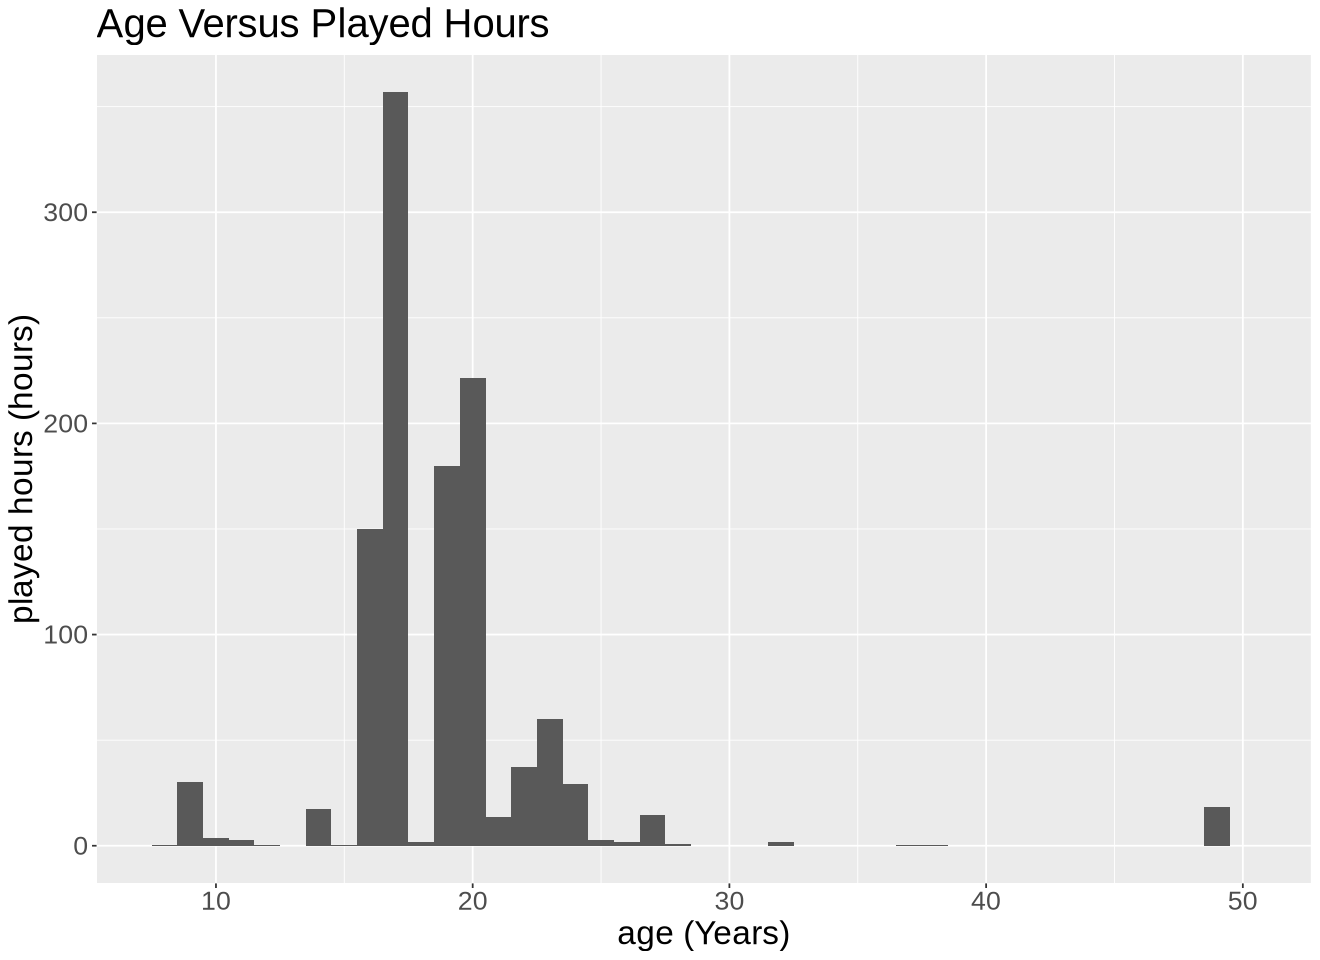

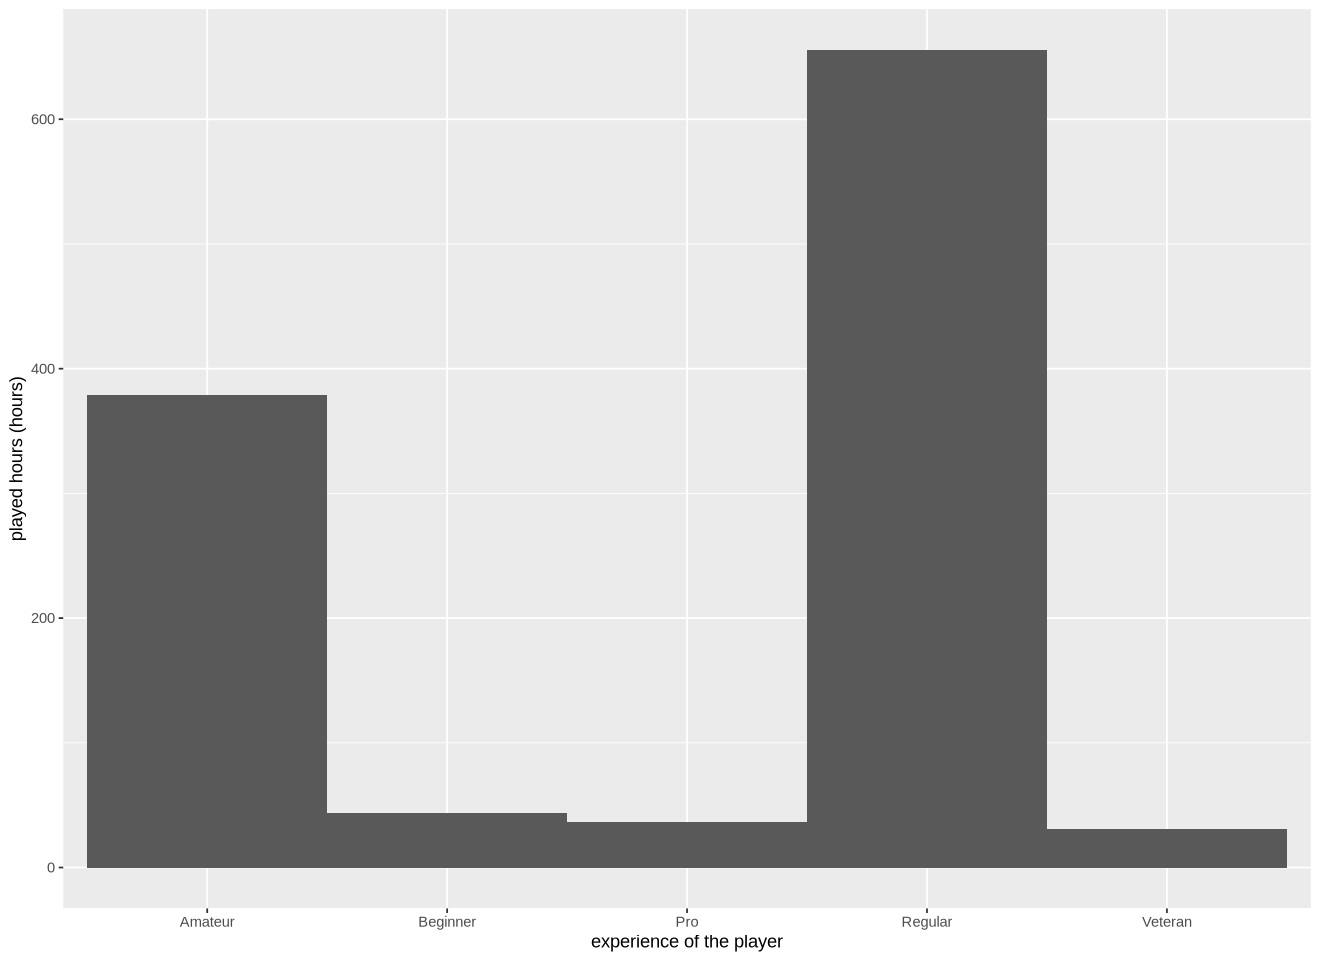

In [4]:
players_age_plot <- players|>
    ggplot(aes(x = Age, y = played_hours)) +
    geom_bar(stat = "identity", width = 1)+
    ylab("played hours (hours)")+
    xlab("age (Years)")+
    ggtitle("Age Versus Played Hours")+
theme(text = element_text(size = 20))
players_age_plot  

players_experience_plot <- players_raw|>
    ggplot(aes(x = experience, y = played_hours)) +
    geom_bar(stat = "identity", width = 1)+
    ylab("played hours (hours)")+
    xlab("experience of the player")
    ggtitle("Played Hours Versus Experience of the Player ")+
theme(text = element_text(size = 20))
players_experience_plot  



Looking at the two plots, it doesn't seem like there is any strong linear relationship between the varibles. Thus, k-nearest neighbors regression will be used to solve this problem.  

# Model

First, we should spilt the data into a training part and a testing part. The training part will be 75% of the data and the testing part will be 25%. 

In [5]:
set.seed(4100)
players_split <- initial_split(players, prop = 0.75, strata = played_hours) #spliting the players data
players_training <- training(players_split)
players_testing <- testing(players_split)

In [6]:
set.seed(4100)
#create a recipe that predicts played hours with the varibles and scale the data
player_recipe <- recipe(played_hours ~ experience + Age + gender + subscribe, data = players_training)|>
    step_scale(all_of(c("experience", "Age")))|> #we cannot scale gender and subscribe
    step_center(all_of(c("experience", "Age")))
#create a model specification for k-nearest neighbors regression
player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
    set_engine("kknn")|>
    set_mode("regression")
#use 5- fold cross validation to find the best k value
player_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

player_workflow <- workflow()|>
    add_recipe(player_recipe)|>
    add_model(player_spec)

We will run cross validation for grid numbers of 1 to 30

In [7]:
set.seed(4100)
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

player_result <- player_workflow|>
    tune_grid(resamples = player_vfold, grid = k_vals)|>
    collect_metrics()|>
     filter(.metric =="rmse")
player_result

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 27 rows.
               ✖ Assigned data has 28 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 28 to size 27.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,43.81542,4,5.842823,Preprocessor1_Model01
2,rmse,standard,38.96478,4,3.854171,Preprocessor1_Model02
3,rmse,standard,39.25159,4,3.238237,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,rmse,standard,34.78328,4,3.281834,Preprocessor1_Model48
49,rmse,standard,34.84145,4,3.251138,Preprocessor1_Model49
50,rmse,standard,34.91300,4,3.255775,Preprocessor1_Model50


In [8]:
player_min <- player_result|>
    filter(mean == min(mean))
player_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
20,rmse,standard,34.03285,4,3.423908,Preprocessor1_Model20


It seems like k = 20 will give us the lowest RMSE. 

# Result

In [9]:
set.seed(4100)
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 20)|>
    set_engine("kknn")|>
    set_mode("regression")

player_fit <- workflow()|>
    add_recipe(player_recipe)|>
    add_model(players_spec)|>
    fit(data = players_training)

players_testing_clean <- players_testing %>% drop_na()


player_summary <- player_fit|>
    predict(players_testing_clean)|>
    bind_cols(players_testing_clean)|>
    metrics(truth = played_hours, estimate = .pred)|>
    filter(.metric == "rmse")
player_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,12.69732


Therefore, a large amount of data in this data set is any played time above 12.7 hours. As mentioned above, we need to filter out those players and find what kind of players are they

In [10]:
large_data <- player_summary|>
    select(.estimate)|>
    pull()

player_filtered <- players|>
    filter(played_hours > large_data)|>
    mutate(experience = factor(experience,
                                   levels = 1:5,
                                   labels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"))) # we don't need the numbers anymore
player_filtered
#nrow(player_filtered)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Amateur,TRUE,a175d4741dc84e6baf77901f6e8e0a06f54809a34e6b5211159bced346f7fb3e,48.4,Xander,Female,17
Regular,TRUE,b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,218.1,Akio,Non-binary,20
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Beginner,TRUE,9782452b8e41d1f140374eec34c84f464df6ed12e2777e5b4f7150912b8ab78c,23.7,Isla,Male,24
Regular,TRUE,ad6390295640af1ed0e45ffc58a53b2d9074b0eea694b16210addd44d7c81f83,178.2,Piper,Female,19
Amateur,TRUE,24d4892c2c3ce11d3e54c3bf31ee218901cac7a2f564911d67424c8fdf0874fe,32.0,Sidney,Male,22


Warning message in geom_histogram(stat = "count", binwidth = 1):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


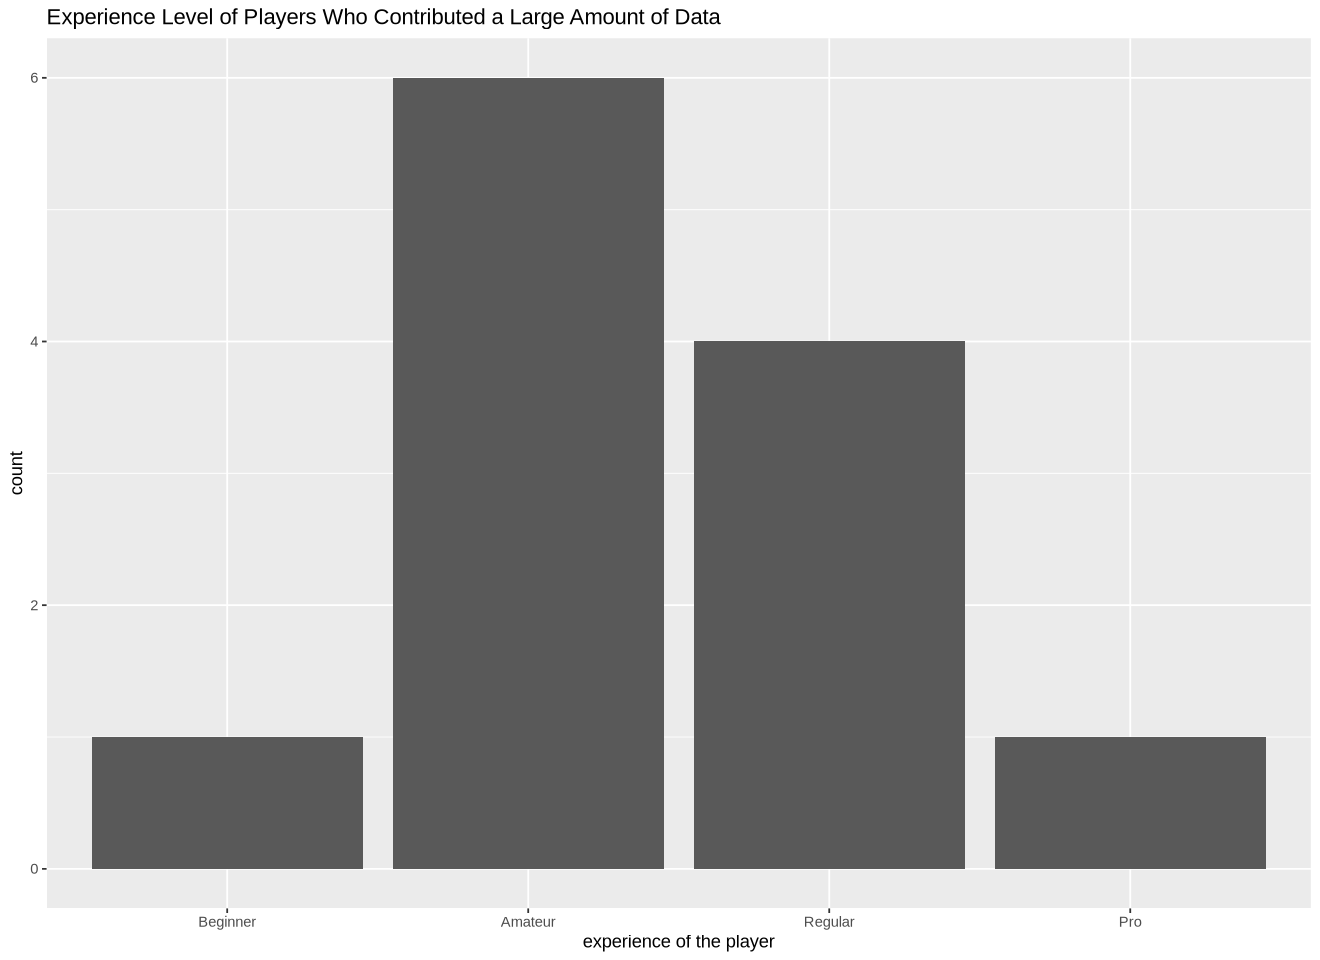

In [11]:
large_contributor_experience_plot <- player_filtered|>
    ggplot(aes(x = experience))+
    geom_histogram(stat= "count", binwidth = 1)+
    labs(x = "experience of the player")+
    ggtitle("Experience Level of Players Who Contributed a Large Amount of Data")
large_contributor_experience_plot

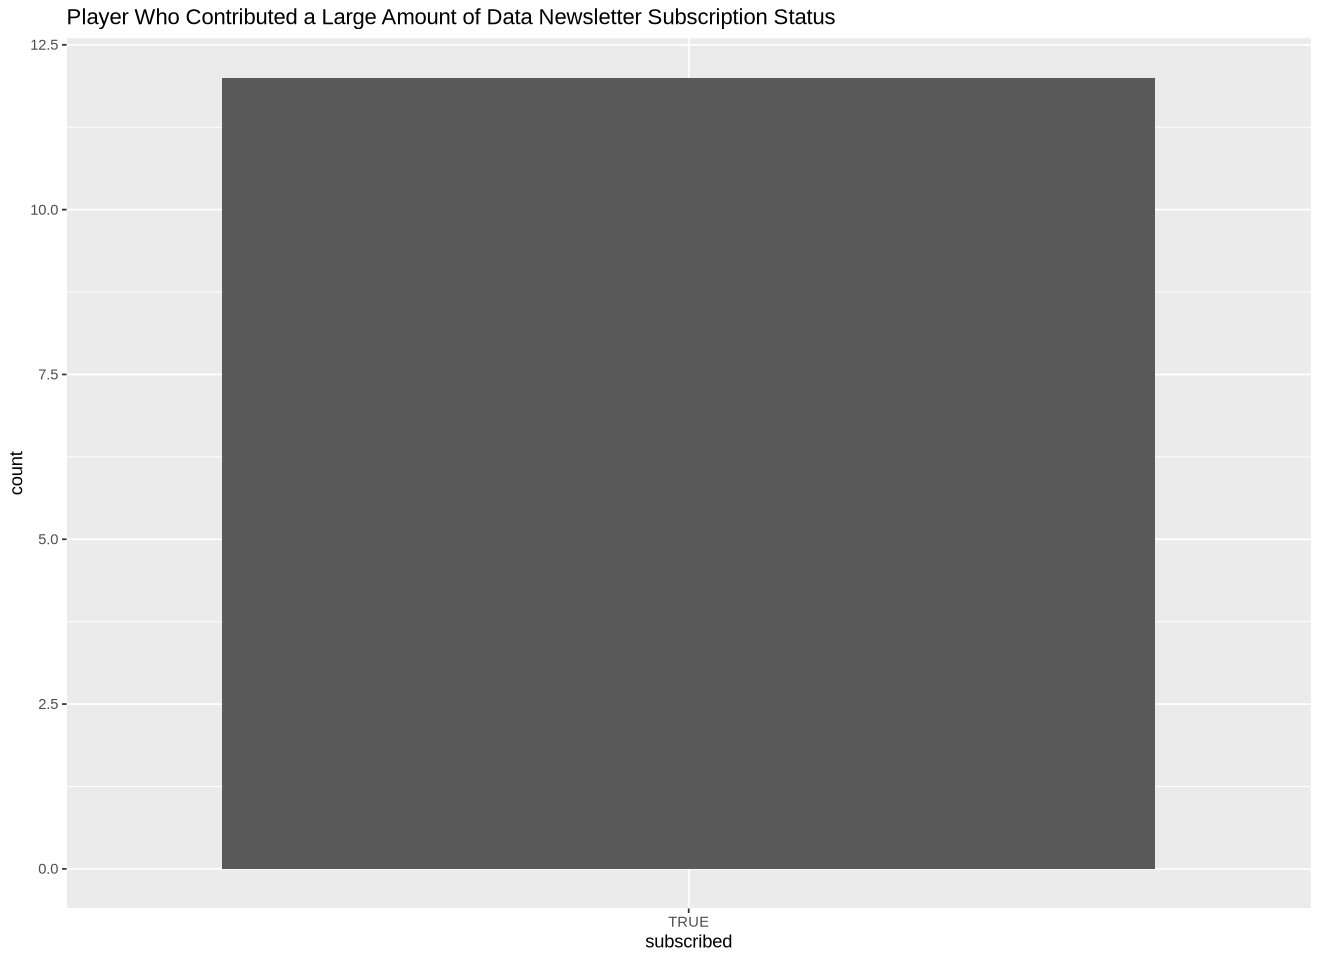

In [12]:
large_contributor_subscribe_plot <- player_filtered|>
    ggplot(aes(x = subscribe))+
    geom_bar()+
    labs(x = "subscribed", y = "count")+
    ggtitle("Player Who Contributed a Large Amount of Data Newsletter Subscription Status")
large_contributor_subscribe_plot

Warning message in geom_histogram(stat = "count", binwidth = 1):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


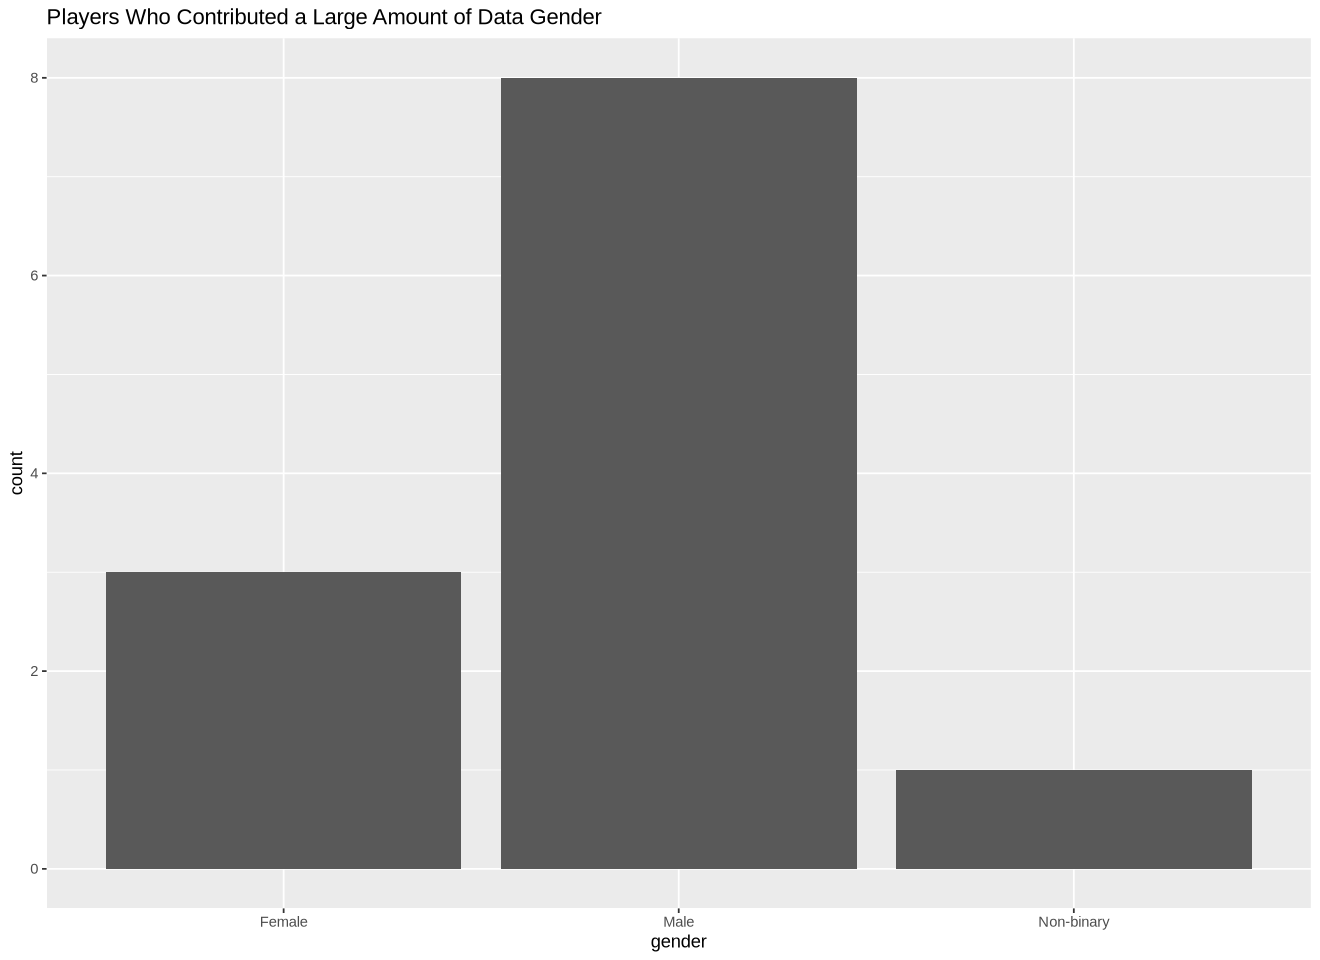

In [13]:
cccccccccccc <- player_filtered|>
    ggplot(aes(x = gender))+
    geom_histogram(stat= "count", binwidth = 1)+
    labs(x = "gender")+
    ggtitle("Players Who Contributed a Large Amount of Data Gender")
large_contributor_gender_plot

Warning message in geom_histogram(stat = "count", binwidth = 1):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


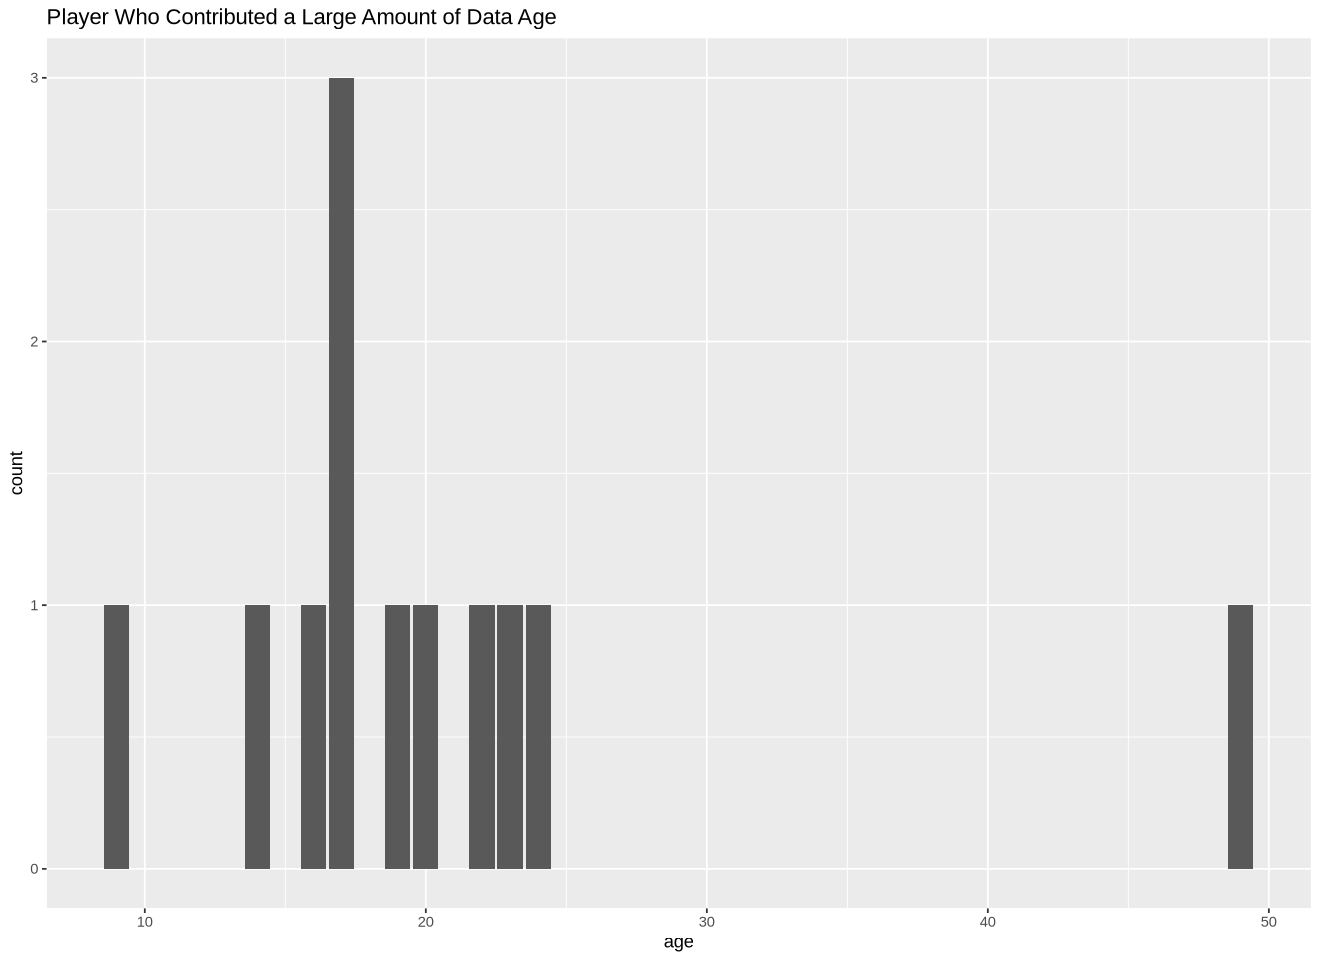

In [14]:
large_contributor_age_plot <- player_filtered|>
    ggplot(aes(x = Age))+
    geom_histogram(stat= "count", binwidth = 1)+
    labs(x = "age")+
    ggtitle("Player Who Contributed a Large Amount of Data Age")
large_contributor_age_plot

In [39]:
# player_long <- player_filtered|>
#     mutate(across(c(Age, gender, experience, subscribe), as.character))|>
#     pivot_longer(cols = c(experience, subscribe, gender, Age), 
#                      names_to = "feature",
#                      values_to = "value")|>



# large_contributor_plot <- ggplot(player_long, aes(x = value))+
#     geom_bar(fill = "steelblue")+
#     facet_wrap(~ feature, scales = "free_x", ncol = 2) +
#     labs(x = NULL, y = "Count", title = "Distribution of Large Contributor Characteristics")+
#     theme(axis.text.x = element_text(angle = , hjust = 1))
# large_contributor_plot

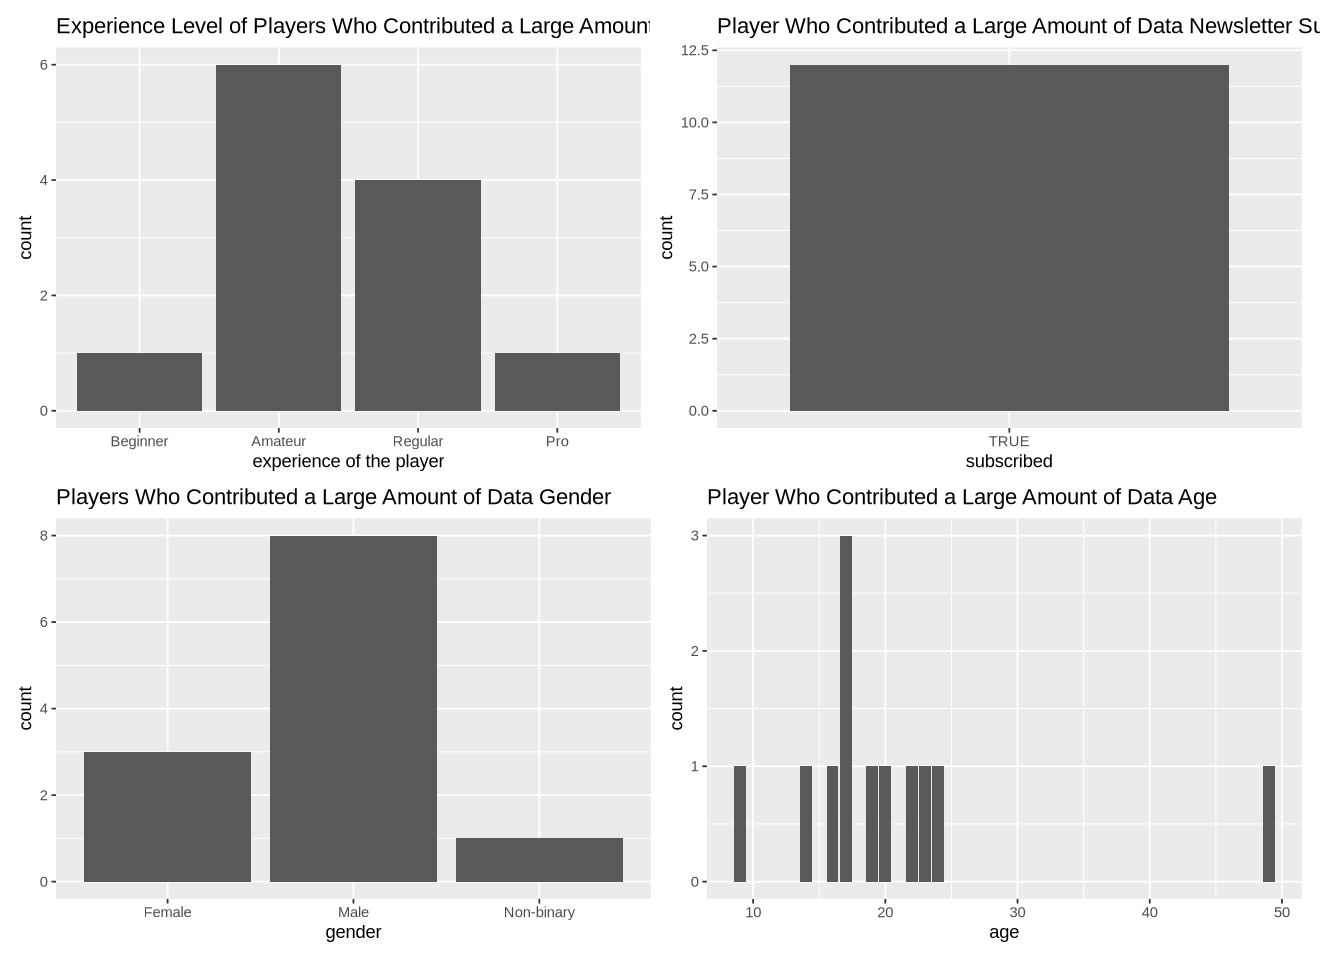

In [41]:
# i tried facet_grid and it is a compelete mess
library(patchwork)# with the help of gpt
(large_contributor_experience_plot|large_contributor_subscribe_plot)/(large_contributor_gender_plot|large_contributor_age_plot)

# Discussion